# Analyzing results of grid search

This notebook assumes you've downloaded data and run a grid search experiment
```sh
make update  # many hours
python mutrans.py --grid-search  # many hours
```

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 200

In [2]:
df = pd.read_csv("results/grid_search.tsv", sep="\t")
df = df.fillna("")
df

,model_type,cond_data,England B.1.1.7 MAE,England B.1.1.7 RMSE,England MAE,England RMSE,MAE,RMSE,loss,|μ|/σ max,...,ΔlogR(S:D614G) mean,ΔlogR(S:D614G) std,ΔlogR(S:E484K) mean,ΔlogR(S:E484K) std,ΔlogR(S:L452R) mean,ΔlogR(S:L452R) std,ΔlogR(S:N501Y) mean,ΔlogR(S:N501Y) std,ρ_lineage,ρ_mutation
0,reparam,,0.033813,0.154423,0.000532,0.007559,0.001197,0.016916,866913.500,621.453491,...,4.017673,0.036467,-3.593361,0.025748,0.436764,0.041297,-4.121752,0.012444,0.377741,0.073941
1,reparam,feature_scale=0.2,0.034262,0.155568,0.000518,0.007158,0.001197,0.017731,884084.750,994.850037,...,7.361218,0.017640,6.985264,0.035924,12.046176,0.061213,4.853712,0.022856,0.793262,0.166750
2,reparam,feature_scale=0.1,0.034561,0.156086,0.000518,0.007506,0.001196,0.017377,893513.625,917.325012,...,8.677524,0.015776,7.946883,0.037940,13.752214,0.068065,8.413511,0.031237,0.876371,0.337561
3,reparam-overdispersed,,0.039764,0.159935,0.000571,0.007590,0.001196,0.015425,5942642.000,2844.575684,...,0.530799,0.000187,2.295478,0.002162,1.088310,0.003249,2.724289,0.002013,0.419051,0.191402
4,reparam-overdispersed,feature_scale=0.2,0.039415,0.159820,0.000566,0.007563,0.001189,0.015180,5957657.750,2820.976807,...,1.120598,0.000397,1.033349,0.004962,1.400907,0.007014,1.217977,0.003206,0.601445,0.275459
5,reparam-overdispersed,feature_scale=0.1,0.039911,0.159957,0.000570,0.007531,0.001190,0.015166,5961075.250,3079.258545,...,0.905645,0.000294,2.006186,0.005182,2.299845,0.007202,1.301819,0.003806,0.653495,0.276707
6,reparam-biased,,0.028774,0.144606,0.000460,0.006970,0.001177,0.018548,924919.750,740.769592,...,12.957496,0.022829,-1.753517,0.028747,6.913398,0.043885,-0.888843,0.012961,0.617829,0.295944
7,reparam-biased,feature_scale=0.2,0.029569,0.146548,0.000460,0.007081,0.001173,0.017488,884674.875,646.790588,...,14.428947,0.022309,5.127013,0.041882,13.415911,0.062827,3.740321,0.021016,0.823388,0.451111
8,reparam-biased,feature_scale=0.1,0.029559,0.146609,0.000460,0.007185,0.001172,0.017458,886184.500,780.762512,...,14.809658,0.018968,5.272370,0.050855,15.017436,0.083437,4.450435,0.023620,0.902173,0.631930
9,reparam-biased-overdispersed,,0.039875,0.159926,0.000562,0.007693,0.001190,0.015293,5882447.750,1769.514526,...,-0.028807,0.000301,3.042270,0.002235,1.981658,0.011399,1.413304,0.001662,0.522570,0.285131


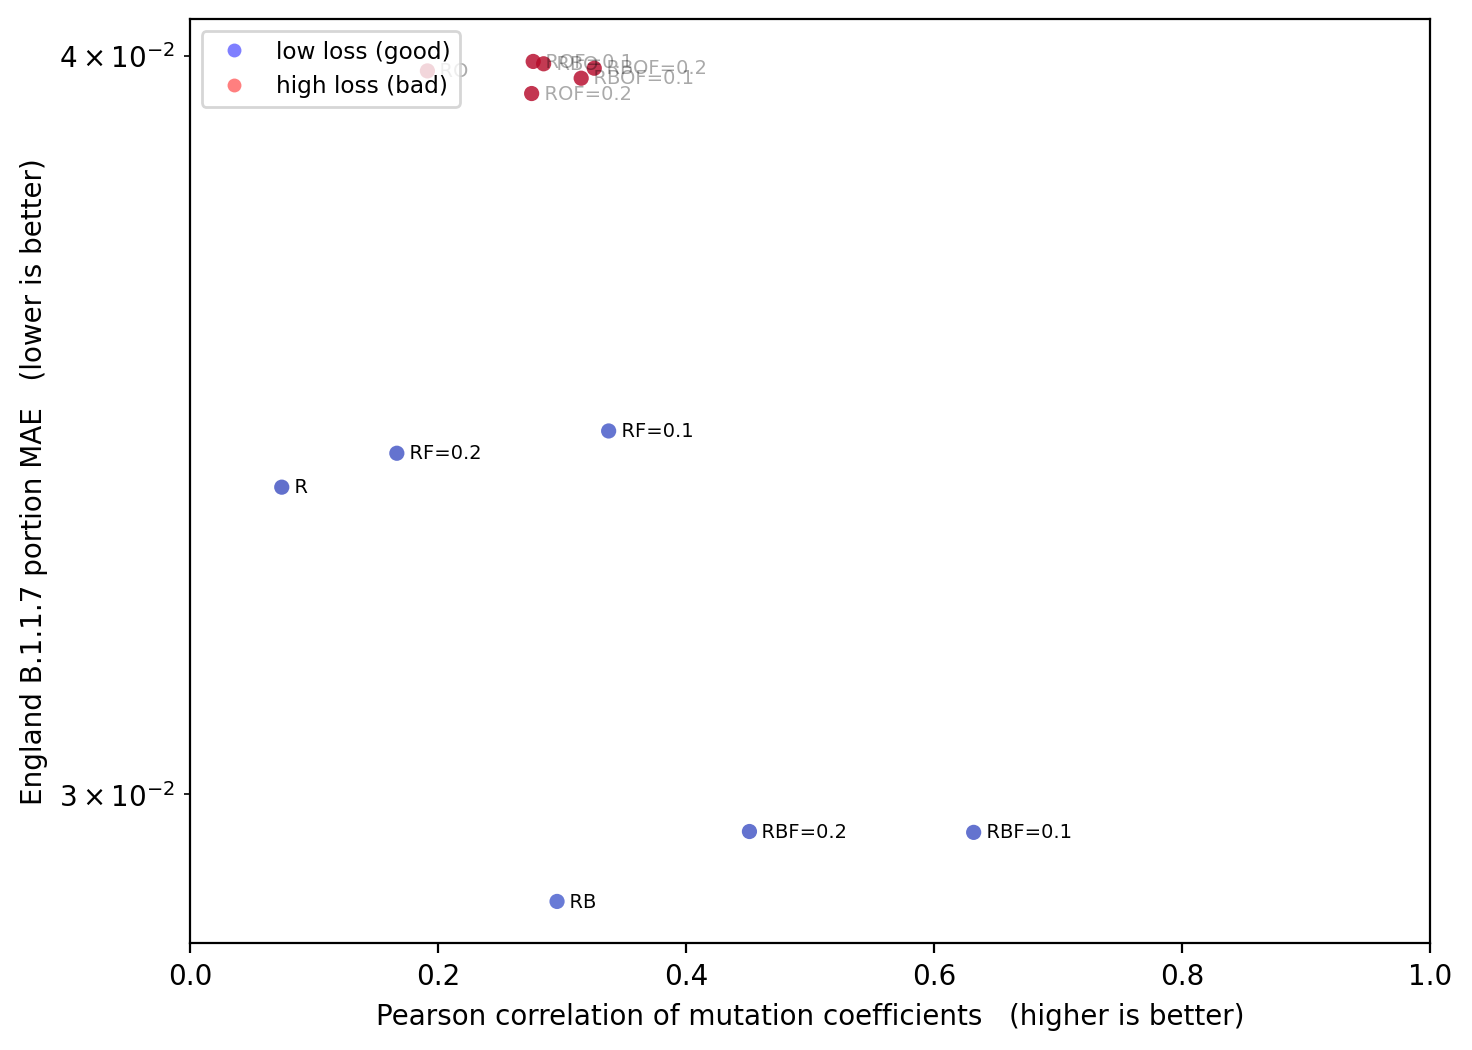

In [3]:
model_type = df["model_type"].to_list()
cond_data = df["cond_data"].to_list()
corr = df["ρ_mutation"].to_numpy()
mae = df["England B.1.1.7 MAE"].to_numpy()
loss = df["loss"].to_numpy()
assert (loss > 0).all(), "you'll need to switch to symlog or sth"
loss = np.log(loss)
loss -= loss.min()
loss /= loss.max()

def plot_corr_vs_mae():
    plt.figure(figsize=(8, 6))
    plt.scatter(corr, mae, 30, loss, lw=0, alpha=0.8, cmap="coolwarm")
    plt.xlabel("Pearson correlation of mutation coefficients   (higher is better)")
    plt.ylabel("England B.1.1.7 portion MAE   (lower is better)")
    for x, y, mt, cd, l in zip(corr, mae, model_type, cond_data, loss):
        name = (
            f"  {mt}{cd}"
            .replace("feature_scale", "F")
            .replace("reparam", "R")
            .replace("locally", "L")
            .replace("biased", "B")
            .replace("overdispersed", "O")
            .replace("dirichlet", "D")
            .replace("-", "")
        )
        plt.text(x, y, name, fontsize=7, va="center", alpha=1 - 0.666 * l)
    plt.plot([], [], "bo", markeredgewidth=0, markersize=5, alpha=0.5, label="low loss (good)")
    plt.plot([], [], "ro", markeredgewidth=0, markersize=5, alpha=0.5, label="high loss (bad)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xlim(0, 1)
    plt.yscale("log")
plot_corr_vs_mae()